# Covid X-Ray Image Classification

The dataset folder includes ground-truth images of each class (310 negative and 150 positive). 

The task is to provide an AI solution that can classify images as a positive or negative covid case.

In [1]:
##Other
import glob

import matplotlib.pyplot as plt

#Model
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

##Data & Transforms
import config
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torch.optim import lr_scheduler

from dataset import ImageFolder
from train import train_model, train

##Metrics
from sklearn.metrics import f1_score

In [2]:
# define paths
import os
cwd = os. getcwd()
covid_path = cwd+'/dataset/covid_p'
noncovid_path = cwd+'/dataset/covid_n'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob.glob(covid_path + '/*')
noncovid_files = glob.glob(noncovid_path + '/*')


## 1st observation - Class Imbalance

150 310


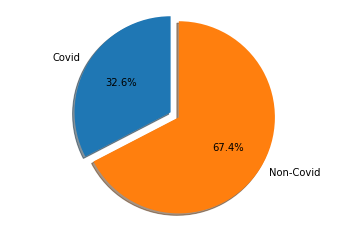

In [3]:
print(len(covid_files), len(noncovid_files))

# Pie chart where the slices will be ordered and plotted counter-clockwise:
labels = 'Covid', 'Non-Covid'
sizes = [len(covid_files), len(noncovid_files)]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
# 2nd observation - Different Image sizes


A look at the dataset

In [5]:
print(config.BATCH_SIZE)

8


In [4]:
#create train test split
train_ds = ImageFolder(root_dir="dataset/", transform = config.train_transforms)

class_weights=[1,2]
sample_weights = [0] * len(train_ds)
for idx, (data, label) in enumerate(train_ds):
    class_weight = class_weights[label]
    sample_weights[idx]=class_weights
# Sampler not used for the moment
#sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
train_size = int(0.8 * len(train_ds))
test_size = len(train_ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_ds, [train_size, test_size])
train_dataset.transform = config.train_transforms
test_dataset.transform = config.val_transforms

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS,pin_memory=config.PIN_MEMORY, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS,pin_memory=config.PIN_MEMORY,shuffle=True)



In [5]:
num_noncovid = 0
num_covid = 0
for epoch in range(10):
    data, labels = next(iter(train_loader))
    num_noncovid+=torch.sum(labels==0)
    num_covid+=torch.sum(labels==1)
print(num_noncovid)
print(num_covid)

num_noncovid = 0
num_covid = 0
for epoch in range(10):
    data, labels = next(iter(val_loader))
    num_noncovid+=torch.sum(labels==0)
    num_covid+=torch.sum(labels==1)
print(num_noncovid)
print(num_covid)

tensor(56)
tensor(24)
tensor(61)
tensor(19)


## A look at the dataset 
observation (some are grayscaled and some are RGB)

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


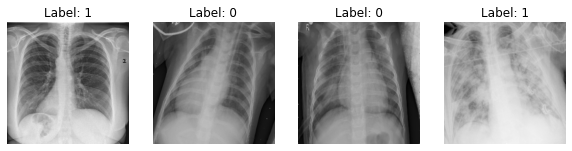

In [5]:
# Display image and label.
val_features, val_labels = next(iter(val_loader))
print(f"Feature batch shape: {val_features.size()}")
print(f"Labels batch shape: {val_labels.size()}")

nrows, ncols = 1, 4
figsize = [10, 6]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
for i, axi in enumerate(ax.flat):
    img = val_features[i]
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    axi.imshow(img)
    axi.set_axis_off()
    label = val_labels[i]
    axi.set_title(f"Label: {label}")


#plt.imshow(img)
#plt.show()

### Create Device (on GPU if available)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## About the Model

Transfer Learning - Scenario with ConvNet as fixed feature extractor

Here, we will freeze the weights for all of the network except that of the final fully connected layer. 
This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

feature_extract=True
use_pretrained=True
model_ft = models.vgg11(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
input_size = 224

In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

#  We will only update the parameter that we have just initialized, i.e. the parameters with requires_d is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if True:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [10]:
%load_ext tensorboard
%tensorboard --logdir runs

In [32]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:

num_epochs = 25
mloss = nn.CrossEntropyLoss(weight= torch.tensor(class_weights).type(torch.FloatTensor).to(device))

dataloaders = {"train": train_loader, "val": val_loader}
# Optimizer
#optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr=0.0005, weight_decay=0.1)

#Logger
#logger = SummaryWriter("/logs")

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft, val_acc_history, loss_history, f1_history = train(model_ft, mloss, optimizer, exp_lr_scheduler, dataloaders, device,  num_epochs=num_epochs)
#m, validaccuracy = train_model(model_ft, dataloaders, mloss, optimizer, device, num_epochs=num_epochs,is_inception=False)# decay=0.1, valid_interval=2, learning_rate=0.0001)

#logger.flush()
#logger.close()

Epoch 0/24
----------
train Loss: 0.6015 Acc: 0.6929  F1: 0.6996
val Loss: 0.4626 Acc: 0.8370  F1: 0.7267
Epoch 1/24
----------
train Loss: 0.4107 Acc: 0.8451  F1: 0.8479
val Loss: 0.4106 Acc: 0.8370  F1: 0.8459
Epoch 2/24
----------
train Loss: 0.3737 Acc: 0.8614  F1: 0.8635
val Loss: 0.3714 Acc: 0.8696  F1: 0.8653
Epoch 3/24
----------
train Loss: 0.3387 Acc: 0.8750  F1: 0.8777
val Loss: 0.3644 Acc: 0.8804  F1: 0.8785
Epoch 4/24
----------
train Loss: 0.3397 Acc: 0.8750  F1: 0.8773
val Loss: 0.3477 Acc: 0.8696  F1: 0.8762
Epoch 5/24
----------
train Loss: 0.3218 Acc: 0.8641  F1: 0.8670
val Loss: 0.3696 Acc: 0.8696  F1: 0.8679
Epoch 6/24
----------
train Loss: 0.3440 Acc: 0.8723  F1: 0.8740
val Loss: 0.3222 Acc: 0.8804  F1: 0.8760
Epoch 7/24
----------
train Loss: 0.3743 Acc: 0.8424  F1: 0.8454
val Loss: 0.2942 Acc: 0.9022  F1: 0.8570
Epoch 8/24
----------
train Loss: 0.3194 Acc: 0.8750  F1: 0.8772
val Loss: 0.3333 Acc: 0.8696  F1: 0.8762
Epoch 9/24
----------
train Loss: 0.3177 Acc: 

In [ ]:
import numpy as np
ohist = []

hist_acc = [h.cpu().numpy() for h in val_acc_history]
hist_loss  = [h.cpu().numpy() for h in loss_history]
hist_f1 = [h.cpu().numpy() for h in f1_history]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(gt,predictions),annot=True, fmt='d',xticklabels=['non-covid','covid'],yticklabels=['non-covid','covid'],cmap='B')



In [27]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [35]:

class_names = ["covid", "no covid"]
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

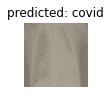

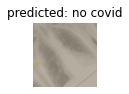

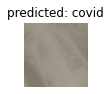

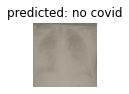

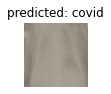

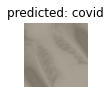

In [37]:
visualize_model(model_ft)

plt.ioff()
plt.show()